In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [17]:
baseline_df = pd.read_excel("/Users/apple/Downloads/Final Project Baseline Values.xlsx", header = None, names = ['metric','baseline_val'])


In [18]:
baseline_df

,metric,baseline_val
0,Unique cookies to view course overview page pe...,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,"Probability of enrolling, given click:",0.206250
5,"Probability of payment, given enroll:",0.530000
6,"Probability of payment, given click",0.109313


## Standard Deviation

I choose three evaluation metrics: gross conversion, retention and net conversion.

The standard deviation is σ = sqrt [ p(1 - p) / n ]


In [38]:
# Gross conversion

gc_sd = round(np.sqrt(0.206250 * (1-0.206250)/ (5000/40000 * 3200)), 4)
print("The standard deviation of gross conversion:", gc_sd)

# Retention

retention_sd = round(np.sqrt((0.530000 * (1-0.530000))/ (5000/40000 * 660)), 4)
print("The standard deviation of retention:", retention_sd)


# Net conversion

net_sd = round(np.sqrt((0.109313 * (1-0.109313))/ (5000/40000 * 3200)) , 4)
print("The standard deviation of net conversion:", net_sd)



The standard deviation of gross conversion: 0.0202
The standard deviation of retention: 0.0549
The standard deviation of net conversion: 0.0156


## Experiment Size

In [46]:
#sample size is calcuated by https://www.evanmiller.org/ab-testing/sample-size.html

gc_sample = 25835
gc_pageviews = gc_sample * 2 * (40000 / 3200)
print("The pageviews needed for gross conversion:", gc_pageviews)

retention_sample = 39155
retention_pageviews = retention_sample * 2 * (40000 / 660)
print("The pageviews needed for retention:", retention_pageviews)


nc_sample = 27413
nc_pageviews = nc_sample * 2 * (40000 / 3200)
print("The pageviews needed for net conversion:", nc_pageviews)



The pageviews needed for gross conversion: 645875.0
The pageviews needed for retention: 4746060.606060606
The pageviews needed for net conversion: 685325.0


## Experiment Duration

In [49]:
gc_dur = gc_pageviews / 40000
print("The duration for gross conversion:", gc_dur)

retention_dur = retention_pageviews / 40000
print("The duration for retention metric:", retention_dur)

nc_dur = nc_pageviews / 40000
print("The duration for net conversion:", nc_dur)


The duration for gross conversion: 16.146875
The duration for retention metric: 118.65151515151516
The duration for net conversion: 17.133125


We drop the retention as it will take a very long time to launch the experiment.

## Sanity Check

In [2]:
ctl_df = pd.read_csv("/Users/apple/Downloads/Final Project Results - Control.csv")
exp_df = pd.read_csv("/Users/apple/Downloads/Final Project Results - Experiment.csv")

In [46]:
exp_df.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


In [45]:
ctl_df.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


Check whether the cookies to view pages and the cookies to click the button are randomly assigned in control and experiment group.


In [3]:
check = {"Control":pd.Series([ctl_df.Pageviews.sum(),ctl_df.Clicks.sum()],
                                  index = ["num_cookie_viewpage","num_cookie_click"]),
           "Experiment":pd.Series([exp_df.Pageviews.sum(),exp_df.Clicks.sum()],
                               index = ["num_cookie_viewpage","num_cookie_click"])}
check_df = pd.DataFrame(check)
check_df

,Control,Experiment
num_cookie_viewpage,345543,344660
num_cookie_click,28378,28325


In [4]:
check_df['frac_of_control'] = check_df.Control / (check_df.Control+check_df.Experiment)
check_df['SD'] = np.sqrt(0.5*(1-0.5)/(check_df.Control+check_df.Experiment))
check_df['ME_with_95_CI'] = check_df.SD * 1.96
check_df['lower_bound'] = 0.5 - check_df.ME_with_95_CI
check_df['upper_bound'] = 0.5 + check_df.ME_with_95_CI
check_df['Falls_in_CI'] = (check_df.frac_of_control >= check_df.lower_bound)&(check_df.frac_of_control <= check_df.upper_bound)

check_df

,Control,Experiment,frac_of_control,SD,ME_with_95_CI,lower_bound,upper_bound,Falls_in_CI
num_cookie_viewpage,345543,344660,0.500640,0.000602,0.001180,0.498820,0.501180,True
num_cookie_click,28378,28325,0.500467,0.002100,0.004116,0.495884,0.504116,True


Check the Click_through-probabily from control and experiment group.

In [5]:
control_ctp = check_df.Control.num_cookie_click/check_df.Control.num_cookie_viewpage
experiment_ctp = check_df.Experiment.num_cookie_click/check_df.Experiment.num_cookie_viewpage
pooled_prob = (check_df.Control.num_cookie_click+check_df.Experiment.num_cookie_click) / (check_df.Control.num_cookie_viewpage + check_df.Experiment.num_cookie_viewpage)
pooled_SE = np.sqrt(pooled_prob * (1 - pooled_prob) * (1/check_df.Control.num_cookie_viewpage + 1/check_df.Experiment.num_cookie_viewpage))
diff = control_ctp - experiment_ctp
ME_95_CI = 1.96* pooled_SE
lower_bound = -ME_95_CI
upper_bound = ME_95_CI
falls_in_CI = (diff>=lower_bound)&(diff<=upper_bound)
print("Control ctp: {:.4f}, experiment ctp: {:.4f}, pooled probability is {:.4f}, pooled standard error: {:.4f}, \ndifference between groups: {:.4f}, margin error: {:.4f}, lower bound: {:.4f}, upper bound: {:.4f}."
          .format(control_ctp, experiment_ctp,pooled_prob, pooled_SE, diff, ME_95_CI, lower_bound, upper_bound))

print ("Wether falls in the CI:", falls_in_CI)


Control ctp: 0.0821, experiment ctp: 0.0822, pooled probability is 0.0822, pooled standard error: 0.0007, 
difference between groups: -0.0001, margin error: 0.0013, lower bound: -0.0013, upper bound: 0.0013.
Wether falls in the CI: True


## Practical and Statistical Significance 

In [6]:
# remove the records that have null enrollments or payments
ctl_temp_df = ctl_df.dropna()
exp_temp_df = exp_df.dropna()

In [47]:
ctl_temp_df['gross_conversion'] = ctl_temp_df['Enrollments']/ctl_temp_df['Clicks']
ctl_temp_df['net_conversion'] = ctl_temp_df['Payments']/ctl_temp_df['Clicks']

ctl_temp_df.head()

,Date,Pageviews,Clicks,Enrollments,Payments,gross_conversion,net_conversion
0,"Sat, Oct 11",7723,687,134.0,70.0,0.195051,0.101892
1,"Sun, Oct 12",9102,779,147.0,70.0,0.188703,0.089859
2,"Mon, Oct 13",10511,909,167.0,95.0,0.183718,0.104510
3,"Tue, Oct 14",9871,836,156.0,105.0,0.186603,0.125598
4,"Wed, Oct 15",10014,837,163.0,64.0,0.194743,0.076464


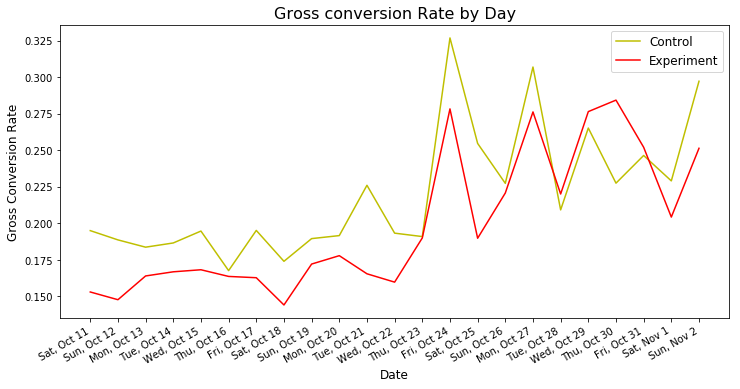

In [41]:
# visualization
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ctl_temp_df['Date'], ctl_temp_df['gross_conversion'], 'y-', label="Control")
ax.plot(exp_temp_df['Date'], exp_temp_df['gross_conversion'], 'r-', label = "Experiment")
ax.set_title('Gross conversion Rate by Day', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Gross Conversion Rate', fontsize=12)
ax.legend(fontsize=12)
#ax.grid(True)
fig.autofmt_xdate()
plt.show()

In [48]:
exp_temp_df['gross_conversion'] = exp_temp_df["Enrollments"]/exp_temp_df["Clicks"]
exp_temp_df['net_conversion'] = exp_temp_df["Payments"]/exp_temp_df["Clicks"]

exp_temp_df.head()

,Date,Pageviews,Clicks,Enrollments,Payments,gross_conversion,net_conversion
0,"Sat, Oct 11",7716,686,105.0,34.0,0.153061,0.049563
1,"Sun, Oct 12",9288,785,116.0,91.0,0.147771,0.115924
2,"Mon, Oct 13",10480,884,145.0,79.0,0.164027,0.089367
3,"Tue, Oct 14",9867,827,138.0,92.0,0.166868,0.111245
4,"Wed, Oct 15",9793,832,140.0,94.0,0.168269,0.112981


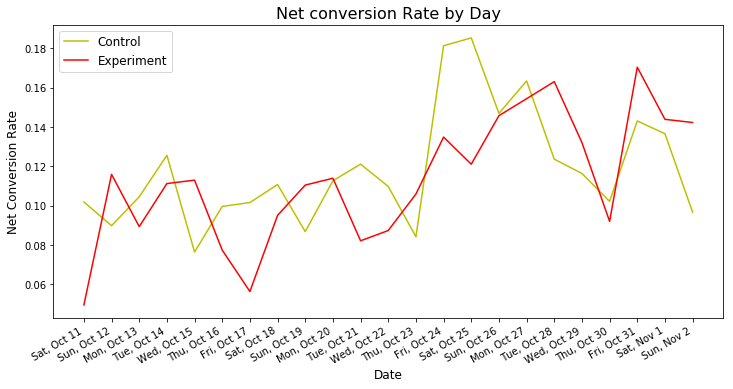

In [42]:
# visualization
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ctl_temp_df['Date'], ctl_temp_df['net_conversion'], 'y-', label="Control")
ax.plot(exp_temp_df['Date'], exp_temp_df['net_conversion'], 'r-', label = "Experiment")
ax.set_title('Net conversion Rate by Day', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Net Conversion Rate', fontsize=12)
ax.legend(fontsize=12)
#ax.grid(True)
fig.autofmt_xdate()
plt.show()

In [89]:
res = {"Control":pd.Series([ctl_temp_df.Enrollments.sum()/ctl_temp_df.Clicks.sum(), ctl_temp_df.Payments.sum()/ctl_temp_df.Clicks.sum()],
                                  index = ["gross_conversion","net_conversion"]),
       "Experiment":pd.Series([exp_temp_df.Enrollments.sum()/exp_temp_df.Clicks.sum(), exp_temp_df.Payments.sum()/exp_temp_df.Clicks.sum()],
                                  index = ["gross_conversion","net_conversion"]),
      "enroll_pay": pd.Series([ctl_temp_df.Enrollments.sum() + exp_temp_df.Enrollments.sum(), ctl_temp_df.Payments.sum() + exp_temp_df.Payments.sum()], 
                              index = ["gross_conversion","net_conversion"])}
                                 
                                 
res_df = pd.DataFrame(res)
res_df

,Control,Experiment,enroll_pay
gross_conversion,0.218875,0.198320,7208.0
net_conversion,0.117562,0.112688,3978.0


In [91]:
res_df['pooled_prob'] = res_df.enroll_pay/(ctl_temp_df.Clicks.sum() + exp_temp_df.Clicks.sum())
res_df['pooled_SE'] = np.sqrt(res_df.pooled_prob * (1- res_df.pooled_prob) * (1/ctl_temp_df.Clicks.sum()+1/exp_temp_df.Clicks.sum()))
res_df['difference'] = res_df.Experiment - res_df.Control
res_df['ME_95_CI'] = 1.96 * res_df.pooled_SE

res_df['lower_bound'] = res_df.difference - res_df.ME_95_CI
res_df['upper_bound'] = res_df.difference + res_df.ME_95_CI
res_df['prac_diff'] = [-0.01, -0.0075]
res_df['Stat_sig'] = (0 <= res_df.lower_bound)|(0 >= res_df.upper_bound)
res_df['Prac_sig'] = (res_df.prac_diff <= res_df.lower_bound)|(res_df.prac_diff >= res_df.upper_bound)
res_df

,Control,Experiment,enroll_pay,pooled_prob,pooled_SE,difference,ME_95_CI,lower_bound,upper_bound,prac_diff,Stat_sig,Prac_sig
gross_conversion,0.218875,0.198320,7208.0,0.208607,0.004372,-0.020555,0.008568,-0.029123,-0.011986,-0.0100,True,True
net_conversion,0.117562,0.112688,3978.0,0.115127,0.003434,-0.004874,0.006731,-0.011605,0.001857,-0.0075,False,False


## Sign Test

In [106]:
dtd_gc = np.sum(ctl_temp_df.Enrollments < exp_temp_df.Enrollments)
pval_gc = stats.binom_test(dtd_gc, n = ctl_temp_df.shape[0], p=0.5, alternative='two-sided')

print("The p-value of gross conversion by day-by-day breakdown is: {:.4f}".format(pval_gc))

The p-value of gross conversion by day-by-day breakdown is: 0.0026


In [107]:
dtd_nc = np.sum(ctl_temp_df.Payments < exp_temp_df.Payments)
pval_nc = stats.binom_test(dtd_nc, n = ctl_temp_df.shape[0], p=0.5, alternative='two-sided')

print("The p-value of net conversion by day-by-day breakdown is: {:.4f}".format(pval_nc))

The p-value of net conversion by day-by-day breakdown is: 0.6776
